# HSCT survival: clustering

## Notebook set-up

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import power_transform

import configuration as config

pd.set_option('display.max_rows', 500)

data_df_file=f'{config.DATA_PATH}/processed/02.1-no-multicollinearity_encoded_all_imputed_data_df.parquet'
feature_types_dict_file=f'{config.DATA_PATH}/processed/01.1-feature_type_dict.pkl'
retrain_tree=True

## 1. Load data

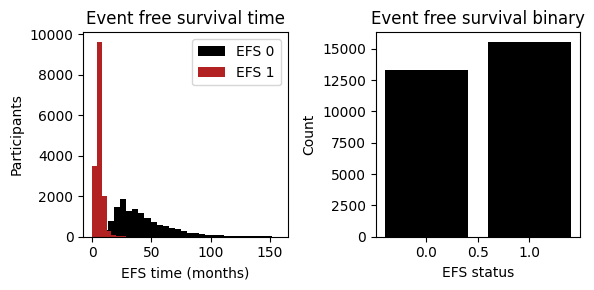

In [2]:
# Load the dataset
data_df=pd.read_parquet(data_df_file)

# Load feature definitions
with open(feature_types_dict_file, 'rb') as input_file:
    feature_types_dict=pickle.load(input_file)

# Take a quick look
efs_neg_df=data_df[data_df['efs'] == 0]
efs_pos_df=data_df[data_df['efs'] == 1]

# Set-up a 1x2 figure
fig, axs=plt.subplots(1,2, figsize=(6,3))
axs=axs.flatten()

axs[0].set_title('Event free survival time')
axs[0].hist(efs_neg_df['efs_time'], bins=30, color='black', label='EFS 0')
axs[0].hist(efs_pos_df['efs_time'], bins=30, color='firebrick', label='EFS 1')
axs[0].set_xlabel('EFS time (months)')
axs[0].set_ylabel('Participants')
axs[0].legend(loc='upper right')

axs[1].set_title('Event free survival binary')
axs[1].bar(data_df['efs'].value_counts().index, data_df['efs'].value_counts(), color='black')
axs[1].set_xlabel('EFS status')
axs[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

## 2. Data preparation

### 2.1. Train-test split

In [3]:
training, testing=train_test_split(data_df, test_size=0.33, random_state=315)

training_df=pd.DataFrame(training, columns=data_df.columns)
testing_df=pd.DataFrame(testing, columns=data_df.columns)

### 2.3. Save and remove un-encoded race group

In [4]:
training_race_group=training_df['race_group']
testing_race_group=testing_df['race_group']

training_df.drop('race_group', axis=1, inplace=True)
testing_df.drop('race_group', axis=1, inplace=True)

### 2.4. Remove year htc

In [5]:
training_df.drop('year_hct', axis=1, inplace=True)
testing_df.drop('year_hct', axis=1, inplace=True)

### 2.2. Box-Cox transform

In [6]:
features=feature_types_dict['Ordinal'] + feature_types_dict['Interval'] + ['efs_time']
features.remove('year_hct')
# training_df['year_hct']=training_df['year_hct']/100
# testing_df['year_hct']=testing_df['year_hct']/100
training_df[features]=power_transform(training_df[features]+1, method='box-cox')
testing_df[features]=power_transform(testing_df[features]+1, method='box-cox')

### 2.4. Make features and labels

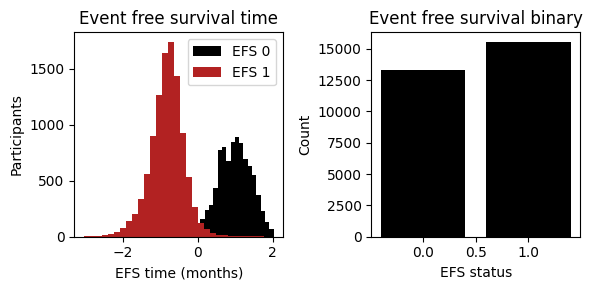

In [7]:
training_labels_df=training_df[['efs', 'efs_time']].copy()
training_features_df=training_df.drop(['efs', 'efs_time'], axis=1)
#training_labels_df['log_efs_time']=np.log(training_labels_df['efs_time'])

testing_labels_df=testing_df[['efs', 'efs_time']].copy()
testing_features_df=testing_df.drop(['efs', 'efs_time'], axis=1)
#testing_labels_df['log_efs_time']=np.log(testing_labels_df['efs_time'])

# Take a quick look
efs_neg_df=training_labels_df[training_labels_df['efs'] == 0]
efs_pos_df=training_labels_df[training_labels_df['efs'] == 1]

# Set-up a 1x2 figure
fig, axs=plt.subplots(1,2, figsize=(6,3))
axs=axs.flatten()

axs[0].set_title('Event free survival time')
axs[0].hist(efs_neg_df['efs_time'], bins=30, color='black', label='EFS 0')
axs[0].hist(efs_pos_df['efs_time'], bins=30, color='firebrick', label='EFS 1')
axs[0].set_xlabel('EFS time (months)')
axs[0].set_ylabel('Participants')
axs[0].legend(loc='upper right')

axs[1].set_title('Event free survival binary')
axs[1].bar(data_df['efs'].value_counts().index, data_df['efs'].value_counts(), color='black')
axs[1].set_xlabel('EFS status')
axs[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [8]:
training_df.head(10).transpose()

ID,1044,9306,24307,1058,24177,6076,16162,22516,28343,23311
hla_match_c_high,-1.551232,0.605538,0.605538,0.605538,0.605538,-1.801021,0.605538,0.605538,-1.801021,0.605538
hla_high_res_8,0.837211,-0.986511,0.837211,0.574689,-0.278621,-1.637188,-0.278621,0.111076,-1.637188,0.837211
hla_low_res_6,-0.090376,-1.612295,0.806635,0.806635,-1.264762,-1.612295,0.806635,-0.090376,-1.612295,0.806635
hla_high_res_6,0.841482,-1.212899,0.841482,0.522966,-0.468435,-1.591159,-0.468435,-0.025203,-1.591159,0.841482
hla_high_res_10,0.859768,-1.221335,0.859768,0.637790,-0.109663,-1.663935,-0.109663,0.237399,-1.663935,0.859768
hla_match_dqb1_high,-0.377409,-1.686427,0.655567,0.655567,0.655567,-1.686427,0.655567,0.655567,-1.686427,0.655567
hla_nmdp_6,-0.114339,-1.635777,0.813259,0.813259,-0.571336,-0.571336,-0.571336,0.159687,-1.635777,0.813259
hla_match_c_low,-0.519834,0.602771,0.602771,0.602771,0.602771,0.602771,0.602771,0.602771,0.602771,0.602771
hla_match_drb1_low,-0.251677,-1.584976,0.673036,0.673036,0.673036,-1.584976,0.673036,-0.251677,-1.584976,0.673036
hla_match_dqb1_low,-0.653310,-1.859082,0.584758,0.584758,0.584758,0.584758,0.584758,0.584758,-1.859082,-1.306351


In [9]:
training_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
hla_match_c_high,19296.0,-5.976424e-16,1.000026,-1.856378,-0.565358,0.605538,0.605538,0.605538
hla_high_res_8,19296.0,2.032647e-16,1.000026,-1.793383,-0.986511,0.837211,0.837211,0.837211
hla_low_res_6,19296.0,6.149494e-17,1.000026,-1.750950,-1.264762,0.806635,0.806635,0.806635
hla_high_res_6,19296.0,-7.898602e-17,1.000026,-1.817129,-1.212899,0.841482,0.841482,0.841482
hla_high_res_10,19296.0,1.653367e-16,1.000026,-1.794703,-0.979010,0.637790,0.859768,0.859768
hla_match_dqb1_high,19296.0,-1.509756e-16,1.000026,-1.781526,-1.005030,0.655567,0.655567,0.655567
hla_nmdp_6,19296.0,2.915486e-16,1.000026,-1.764762,-0.759603,0.813259,0.813259,0.813259
hla_match_c_low,19296.0,-2.581315e-16,1.000026,-1.832826,-0.519834,0.602771,0.602771,0.602771
hla_match_drb1_low,19296.0,-5.678156e-16,1.000026,-1.584976,-1.584976,0.673036,0.673036,0.673036
hla_match_dqb1_low,19296.0,-2.391674e-16,1.000026,-1.902492,-0.653310,0.584758,0.584758,0.584758


## 3. Clustering

### 3.1. Gradient boosting

In [10]:
if retrain_tree == True:
    cv=ShuffleSplit(n_splits=10, test_size=0.3, random_state=315)

    scores=cross_val_score(
        GradientBoostingClassifier(random_state=315),
        training_features_df,
        training_labels_df['efs'],
        cv=cv
    )

    print(f'Cross-validation log-loss: {np.array(scores).mean():.3f} +/- {np.array(scores).std():.3f}')

Cross-validation log-loss: 0.666 +/- 0.003


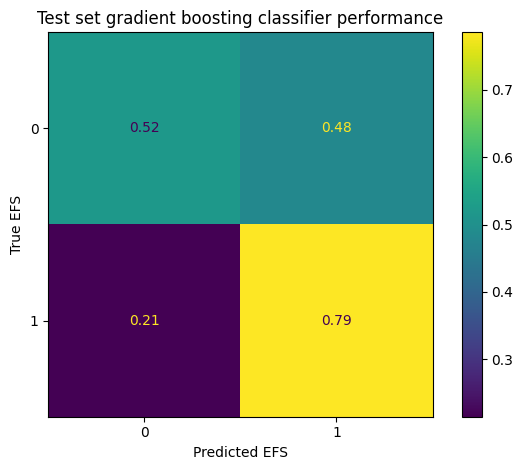

Precision: 0.655
Recall: 0.786



In [11]:
if retrain_tree == True:
    tree_model=GradientBoostingClassifier(random_state=315)
    tree_model.fit(training_features_df, training_labels_df['efs'])

    predictions=tree_model.predict(testing_features_df)

    # Calculate precision and recall
    precision=precision_score(testing_labels_df['efs'], predictions)
    recall=recall_score(testing_labels_df['efs'], predictions)

    # Plot the confusion matrix
    cm=confusion_matrix(testing_labels_df['efs'], predictions, normalize='true')
    cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm)#, display_labels=['0', 'EFS 1'])
    _=cm_disp.plot()

    plt.title('Test set gradient boosting classifier performance')
    plt.xlabel('Predicted EFS')
    plt.ylabel('True EFS')
    plt.tight_layout()
    plt.show()

    print(f'Precision: {precision:.3f}')
    print(f'Recall: {recall:.3f}\n')

### 3.2. Neural network

In [ ]:
l1=0.002
l2=0.0002
learning_rate=0.00001

In [ ]:
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

# Set the weight initializer function
initializer=GlorotUniform(seed=315)

# Set-up the L1L2 for the dense layers
regularizer=L1L2(l1=l1, l2=l2)

# Define the model layers in order
nn_model=Sequential([
    Dense(128, kernel_regularizer=regularizer, activation='relu', kernel_initializer=initializer),
    Dense(256, kernel_regularizer=regularizer, activation='relu', kernel_initializer=initializer),
    Dense(256, kernel_regularizer=regularizer, activation='relu', kernel_initializer=initializer),
    Dense(256, kernel_regularizer=regularizer, activation='relu', kernel_initializer=initializer),
    Dense(128, kernel_regularizer=regularizer, activation='relu', kernel_initializer=initializer),
    Dense(64, kernel_regularizer=regularizer, activation='relu', kernel_initializer=initializer),
    Dense(32, kernel_regularizer=regularizer, activation='relu', kernel_initializer=initializer),
    Dense(16, kernel_regularizer=regularizer, activation='relu', kernel_initializer=initializer),
    Dense(1, activation='sigmoid', kernel_initializer=initializer)
])

nn_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=learning_rate),
    metrics=[Precision(name='precision'), Recall(name='recall')]
)

# Calculate class weighting
pos_examples=sum(training_labels_df['efs'])
neg_examples=len(training_labels_df['efs']) - pos_examples
neg_class_weight=(1 / neg_examples) * (len(training_labels_df['efs']) / 2.0)
pos_class_weight=(1 / pos_examples) * (len(training_labels_df['efs']) / 2.0)

# Do the training run
training_results=nn_model.fit(
    training_features_df,
    training_labels_df['efs'],
    batch_size=256,
    validation_split=0.25,
    epochs=5000,
    # steps_per_epoch=steps_per_epoch,
    # validation_steps=validation_steps,
    verbose=True,
    class_weight={0: neg_class_weight, 1: pos_class_weight}
)

2025-02-21 08:11:47.165171: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2025-02-21 08:11:47.165328: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2025-02-21 08:11:47.165348: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2025-02-21 08:11:52.605512: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7397 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:07:00.0, c

Epoch 1/5000


2025-02-21 08:11:55.388502: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f25d0002a40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-21 08:11:55.388538: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2025-02-21 08:11:55.388550: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): Tesla K80, Compute Capability 3.7
2025-02-21 08:11:55.388559: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (2): Tesla K80, Compute Capability 3.7
2025-02-21 08:11:55.396639: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-21 08:11:55.555282: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


57/57 [==============================] - 5s 17ms/step - loss: 10.6236 - precision: 0.5866 - recall: 0.5622 - val_loss: 10.6195 - val_precision: 0.5681 - val_recall: 0.5580
Epoch 2/5000
57/57 [==============================] - 1s 9ms/step - loss: 10.6148 - precision: 0.5868 - recall: 0.5645 - val_loss: 10.6107 - val_precision: 0.5683 - val_recall: 0.5619
Epoch 3/5000
57/57 [==============================] - 0s 9ms/step - loss: 10.6059 - precision: 0.5877 - recall: 0.5708 - val_loss: 10.6018 - val_precision: 0.5681 - val_recall: 0.5681
Epoch 4/5000
57/57 [==============================] - 1s 9ms/step - loss: 10.5971 - precision: 0.5874 - recall: 0.5739 - val_loss: 10.5930 - val_precision: 0.5684 - val_recall: 0.5720
Epoch 5/5000
57/57 [==============================] - 1s 9ms/step - loss: 10.5883 - precision: 0.5882 - recall: 0.5792 - val_loss: 10.5842 - val_precision: 0.5695 - val_recall: 0.5774
Epoch 6/5000
57/57 [==============================] - 1s 9ms/step - loss: 10.5795 - precisio

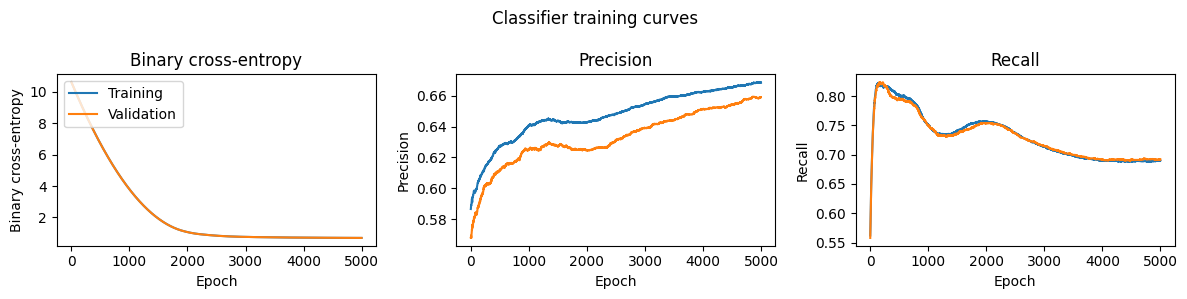

In [14]:
# Set-up a 1x2 figure for binary cross-entropy, precision & recall
fig, axs=plt.subplots(1,3, figsize=(12,3))

# Add the main title
fig.suptitle('Classifier training curves', size='large')

axs[0].set_title('Binary cross-entropy')
axs[0].plot(training_results.history['loss'], label='Training')
axs[0].plot(training_results.history['val_loss'], label='Validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Binary cross-entropy')
axs[0].legend(loc='upper left')

axs[1].set_title('Precision')
axs[1].plot(training_results.history['precision'])
axs[1].plot(training_results.history['val_precision'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Precision')

axs[2].set_title('Recall')
axs[2].plot(training_results.history['recall'])
axs[2].plot(training_results.history['val_recall'])
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Recall')

# Show the plot
plt.tight_layout()

297/297 [==============================] - 1s 2ms/step


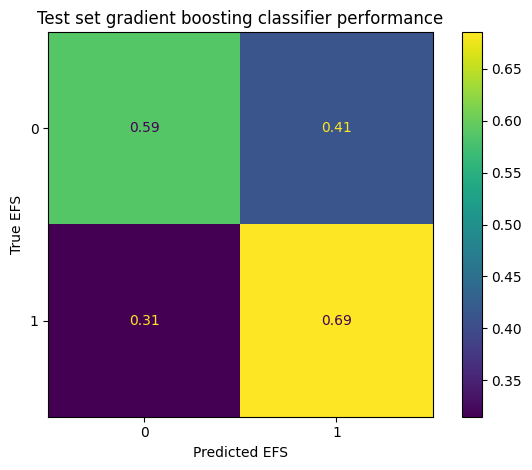

Precision: 0.659
Recall: 0.685



In [15]:
predictions=nn_model.predict(testing_features_df)
calls=list(np.where(np.array(predictions) > 0.5, 1, 0))

# Calculate precision and recall
precision=precision_score(testing_labels_df['efs'], calls)
recall=recall_score(testing_labels_df['efs'], calls)

# Plot the confusion matrix
cm=confusion_matrix(testing_labels_df['efs'], calls, normalize='true')
cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm)#, display_labels=['0', 'EFS 1'])
_=cm_disp.plot()

plt.title('Test set gradient boosting classifier performance')
plt.xlabel('Predicted EFS')
plt.ylabel('True EFS')
plt.tight_layout()
plt.show()

print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}\n')